In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
N_CLASSES = 38


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage dataset/color",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123   
)


Found 42023 files belonging to 27 classes.


In [4]:
class_names = dataset.class_names


In [5]:
class_names


['Apple___Apple_scab',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Soybean___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy']

In [6]:
len(dataset)


1314

it is showing 1698 because the dataset is divided into batched of 32. So the total no. of images are less than 32x1698=54336

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch.numpy())


(32, 256, 256, 3)
[[[[164. 160. 157.]
   [167. 163. 160.]
   [170. 166. 163.]
   ...
   [179. 177. 178.]
   [180. 178. 179.]
   [180. 178. 179.]]

  [[161. 157. 154.]
   [163. 159. 156.]
   [166. 162. 159.]
   ...
   [183. 181. 182.]
   [182. 180. 181.]
   [181. 179. 180.]]

  [[163. 159. 156.]
   [165. 161. 158.]
   [166. 162. 159.]
   ...
   [187. 185. 186.]
   [184. 182. 183.]
   [180. 178. 179.]]

  ...

  [[146. 138. 135.]
   [133. 125. 122.]
   [138. 130. 127.]
   ...
   [133. 128. 125.]
   [129. 124. 121.]
   [144. 139. 136.]]

  [[136. 128. 125.]
   [134. 126. 123.]
   [129. 121. 118.]
   ...
   [139. 134. 131.]
   [139. 134. 131.]
   [136. 131. 128.]]

  [[123. 115. 112.]
   [131. 123. 120.]
   [122. 114. 111.]
   ...
   [162. 157. 154.]
   [164. 159. 156.]
   [134. 129. 126.]]]


 [[[128. 104. 102.]
   [132. 108. 106.]
   [125. 101.  99.]
   ...
   [119.  98.  95.]
   [115.  94.  91.]
   [123. 102.  99.]]

  [[115.  91.  89.]
   [124. 100.  98.]
   [126. 102. 100.]
   ...
   

In [8]:
print(image_batch.shape)


(32, 256, 256, 3)


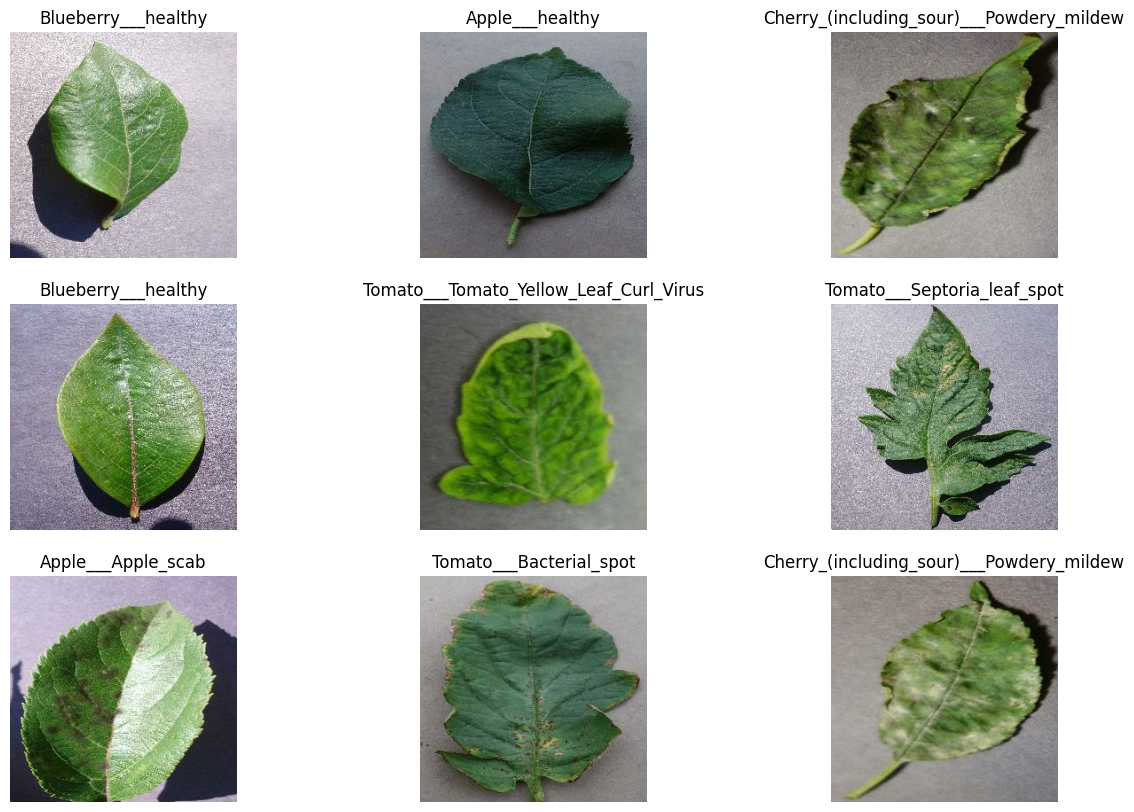

In [9]:
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


### Function to Split Dataset

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [10]:
len(dataset)


1314

In [11]:
def get_dataset_partition(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*dataset_size)
    val_size = int(val_split*dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset
    
    

In [12]:
train_dataset, val_dataset, test_dataset = get_dataset_partition(dataset)


In [13]:
len(train_dataset), len(val_dataset), len(test_dataset)


(1051, 131, 132)

In [14]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [15]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])


In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


In [17]:
train_dataset = train_dataset.map(
    lambda x, y : (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [18]:
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS]),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax'),
])


c:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [21]:
# model.build(input_shape=INPUT_SHAPE)


ValueError: Sequential model 'sequential_2' has already been configured to use input shape (None, 256, 256, 3). You cannot build it with input_shape (32, 256, 256, 3)

In [22]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,872,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,885,190 (30.08 MB)

 Trainable params: 7,885,190 (30.08 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [24]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data = val_dataset,
    verbose=1,
    epochs=EPOCHS   
)


Epoch 1/20


: 

In [ ]:
scores = model.evaluate(test_dataset)


In [ ]:
scores
